
# Feature importances with a forest of trees

This example shows the use of a forest of trees to evaluate the importance of
features on the N2 classification task. The blue bars are the feature
importances of the forest, along with their inter-trees variability represented
by the error bars.

Unexpectedly, the plot suggests that no features are informative.


### Data and model fitting

In [3]:
input_file = "../../data/n2.csv"

In [4]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time
import numpy as np
import pandas as pd

df = pd.read_csv(input_file, header=0, sep=",")

# The input data is everything except the first column
X = df.loc[:, df.columns != 'ctrl/case']
# The outcome or diagnoses are in the first ctrl/case column
y = df['ctrl/case']

# The header row is the feature set
feature_names = list(X.columns)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

A random forest classifier will be fitted to compute the feature importances.

In [6]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Feature importance based on mean decrease in impurity

"Feature importances are provided by the fitted attribute
`feature_importances_` and they are computed as the mean and standard
deviation of accumulation of the impurity decrease within each tree."

<div class="alert alert-danger"><h4>Warning</h4><p>Impurity-based feature importances can be misleading for **high
    cardinality** features (many unique values). See
    `permutation_importance` as an alternative below.</p></div>



In [7]:
n_features = 20

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# get the top 10 
importances_top, std_top, feature_names_top = zip(*sorted(zip(importances, std, feature_names), reverse=True)[0:n_features])

Elapsed time to compute the importances: 0.014 seconds


Let's plot the impurity-based importance.



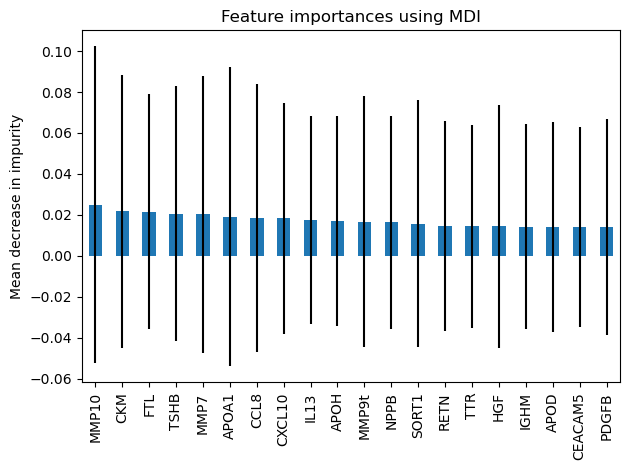

In [8]:
import pandas as pd

forest_importances = pd.Series(importances_top, index=feature_names_top)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std_top, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We observe that no features are found important.

## Feature importance based on feature permutation
"Permutation feature importance overcomes limitations of the impurity-based
feature importance: they do not have a bias toward high-cardinality features
and can be computed on a left-out test set."

In [9]:
from sklearn.inspection import permutation_importance

start_time = time.time()
n_features = 30
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

importances_top, std_top, feature_names_top = zip(*sorted(zip(forest_importances, result.importances_std, feature_names), reverse=True)[0:n_features])


Elapsed time to compute the importances: 8.998 seconds


"The computation for full permutation importance is more costly. Features are
shuffled n times and the model refitted to estimate the importance of it.
Please see `permutation_importance` for more details. We can now plot
the importance ranking."



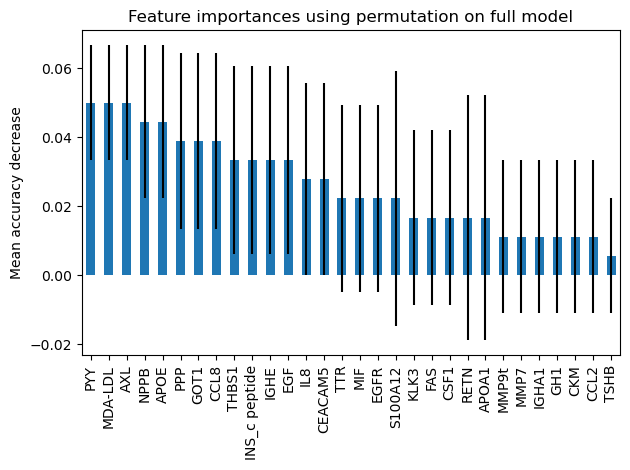

In [10]:
fig, ax = plt.subplots()
perm_importances = pd.Series(importances_top, index=feature_names_top)
pd.Series(importances_top, index=feature_names_top).plot.bar(yerr=std_top, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

There is little contribution from any of the features.